In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import false_discovery_control
from riskyneuroarousal.utils.load_data import load_behavioral_data, load_pupil_data, load_pt_results
from scipy.stats import ttest_ind
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Here, we examine if pupil size is associated with acceptance rates. 

FINISH!!


In [3]:
behavior = load_behavioral_data(min_RT = 0.2)
pupil_data = load_pupil_data()
data = pupil_data.merge(behavior, on=["sub", "trial"])

In [4]:
data["pupil_size"] = data["ps_preprocessed"] - data["baseline"]
data["uncertain"] = data["response_int"].apply(lambda x: "yes" if x == 2 or x == 3 else "no")
data["Accept"] = data["accept"].apply(lambda x: "yes" if x == 1 else "no")

In [5]:
%%R -i data
library(lme4)
library(lmerTest)
library(broom.mixed)

Loading required package: Matrix

Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step



In [6]:
%%R -o all_results
all_results <- data.frame()
for (tb in unique(data$timebin)) {
    # for each timebin, run a linear mixed effects model of ps_preprocessed
    model = glmer(accept ~ condition*pupil_size + (1 | sub), data=data[data$timebin == tb,], family=binomial)
    results <- tidy(model, effects = "fixed", conf.int = TRUE, exponentiate = TRUE, conf.level = 0.95) 
    results$timebin = tb
    all_results = rbind(all_results, results)
}

In [7]:
all_results = all_results.rename(columns={"p.value": "pvalue"})

In [8]:
all_results["pvalue"] = false_discovery_control(all_results["pvalue"], method = "by")

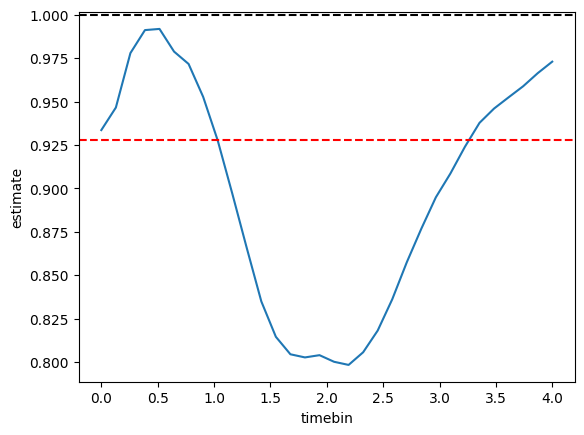

In [9]:
sns.lineplot(all_results.query("term == 'pupil_size'"), x = "timebin", y = "estimate")
if all_results.query("term == 'pupil_size' & pvalue < 0.05").shape[0] > 0:
    plt.axhline(all_results.query("term == 'pupil_size' & pvalue < 0.05")["estimate"].values[0], color="red", linestyle="--")
plt.axhline(1, color="black", linestyle="--")

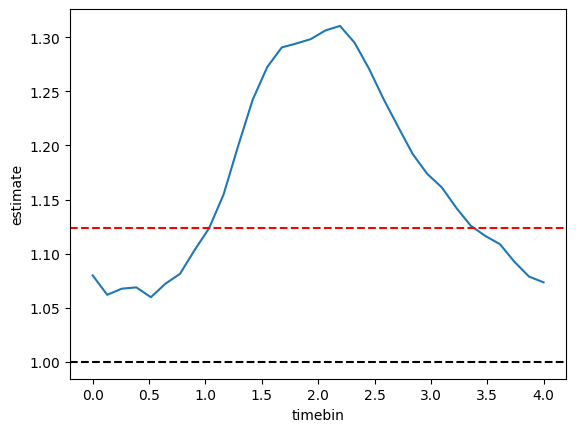

In [10]:
sns.lineplot(all_results.query("term == 'conditionequalRange:pupil_size'"), x = "timebin", y = "estimate")
if all_results.query("term == 'conditionequalRange:pupil_size' & pvalue < 0.05").shape[0] > 0:
    plt.axhline(all_results.query("term == 'conditionequalRange:pupil_size' & pvalue < 0.05")["estimate"].values[0], color="red", linestyle="--")
plt.axhline(1, color="black", linestyle="--")

In [ ]:
sns.lineplot(all_results.query("term == 'pupil_size'"), x = "timebin", y = "estimate")

In [92]:
%%R
modelIndifference <- lmer(RT ~ gain + loss + uncertain + baseline+ (1|sub), data=data[data$condition == 'equalIndifference', ])
modelRange <- lmer(RT ~ gain + loss + uncertain + baseline+(1|sub), data=data[data$condition == 'equalRange', ])

In [94]:
%%R
summary(modelIndifference)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RT ~ gain + loss + uncertain + baseline + (1 | sub)
   Data: data[data$condition == "equalIndifference", ]

REML criterion at convergence: 10063.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.4256 -0.6450 -0.1793  0.4594  5.3460 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept) 0.0779   0.2791  
 Residual             0.2352   0.4850  
Number of obs: 7120, groups:  sub, 28

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   1.448e+00  5.765e-02  3.759e+01  25.127  < 2e-16 ***


gain         -2.920e-03  6.320e-04  7.089e+03  -4.621 3.89e-06 ***
loss          1.214e-02  1.265e-03  7.089e+03   9.597  < 2e-16 ***
uncertainyes  4.349e-01  1.300e-02  7.105e+03  33.460  < 2e-16 ***
baseline     -2.205e-02  5.816e-03  7.093e+03  -3.792 0.000151 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) gain   loss   uncrtn
gain        -0.280                     
loss        -0.253 -0.026              
uncertainys -0.080  0.164 -0.167       
baseline     0.006 -0.031  0.015  0.013


In [95]:
%%R
summary(modelRange)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RT ~ gain + loss + uncertain + baseline + (1 | sub)
   Data: data[data$condition == "equalRange", ]

REML criterion at convergence: 9050.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7211 -0.6662 -0.1734  0.4992  5.4694 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept) 0.08311  0.2883  
 Residual             0.21361  0.4622  
Number of obs: 6868, groups:  sub, 27

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   1.336e+00  5.994e-02  3.470e+01  22.286  < 2e-16 ***
gain         -8.532e-04  1.210e-03  6.837e+03  -0.705    0.481    
loss          9.080e-03  1.211e-03  6.837e+03   7.498 7.28e-14 ***
uncertainyes  2.666e-01  1.225e-02  6.856e+03  21.769  < 2e-16 ***
baseline     -3.326e-02  5.669e-03  6.840e+03  -5.867 4.64e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Cor

In [101]:
%%R
model1 <- glmer(accept ~ condition*gain + condition*loss + condition*baseline + (1|sub), data=data, family=binomial)
summary(model1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: accept ~ condition * gain + condition * loss + condition * baseline +  
    (1 | sub)
   Data: data

     AIC      BIC   logLik deviance df.resid 
  6830.0   6897.9  -3406.0   6812.0    13979 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-264.245   -0.152    0.022    0.199  239.241 

Random effects:
 Groups Name        Variance Std.Dev.
 sub    (Intercept) 4.495    2.12    
Number of obs: 13988, groups:  sub, 55

Fixed effects:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   0.24716    0.43026   0.574   0.5657    
conditionequalRange          -1.00769    0.61254  -1.645   0.0999 .  
gain                          0.32106    0.00889  36.115   <2e-16 ***
loss                         -0.47649    0.01463 -32.561   <2e-16 ***
baseline                     -0.01576    0.04397  -0.358   0.7200

In [47]:
choices = behavior_shared[behavior_shared["gain"]>behavior_shared["loss"]].groupby(["sub", "condition"])["accept"].mean().reset_index()

In [50]:
ttest_ind(choices.query("condition == 'equalIndifference'")["accept"], choices.query("condition == 'equalRange'")["accept"])

TtestResult(statistic=np.float64(-5.821434502876865), pvalue=np.float64(6.295065862633838e-08), df=np.float64(106.0))

In [59]:
pupil_data = pupil_data.merge(behavior, on=["sub", "condition", "trial"])

<Axes: xlabel='gain', ylabel='loss'>

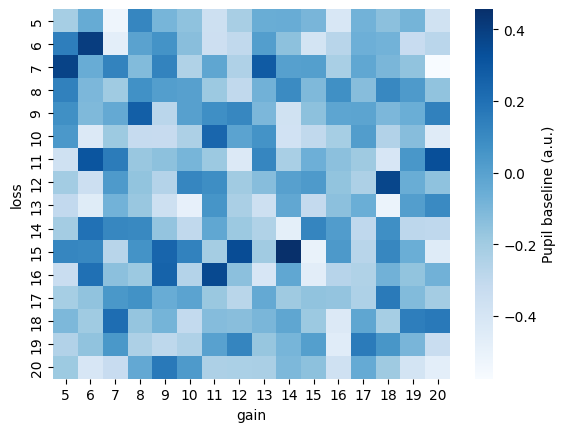

In [66]:
hmap = pupil_data.query("condition == 'equalRange'").groupby(['loss', 'gain'])['baseline'].mean().unstack()
sns.heatmap(hmap, cmap="Blues", cbar_kws={'label': 'Pupil baseline (a.u.)'})

In [97]:
baseline = pupil_data.groupby(["sub", "condition", "trial"])["baseline"].mean().reset_index()

In [ ]:
baseline_mean = pupil_data.groupby(["sub", "condition"])["baseline"].mean().reset_index()
baseline_mean = baseline_mean.merge(pt, on=["sub", "condition"])

In [53]:
baseline_mean = baseline_mean.merge(choices, on=["sub", "condition"])

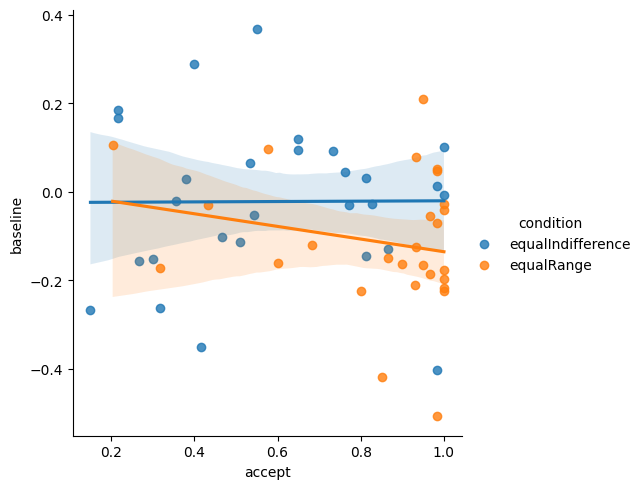

In [55]:
sns.lmplot(baseline_mean.query("param_name == 'lambda'"), x="accept", y="baseline", hue="condition")

In [12]:
ttest_ind(pupil_data.query("condition=='equalIndifference'")["baseline"], pupil_data.query("condition=='equalRange'")["baseline"])

TtestResult(statistic=np.float64(5.4003912392797835), pvalue=np.float64(6.757525128026658e-08), df=np.float64(14078.0))

<Axes: xlabel='baseline', ylabel='Density'>

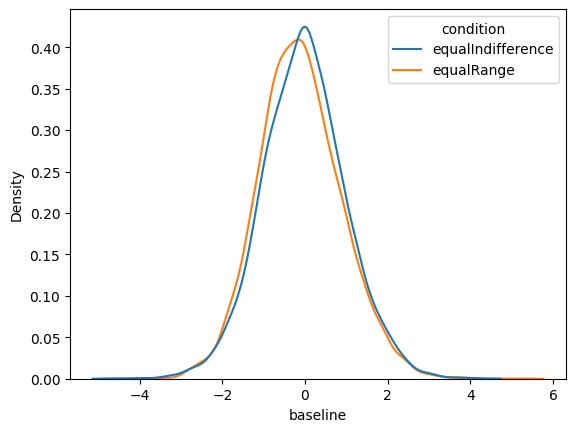

In [100]:
sns.kdeplot(data=baseline, x="baseline", hue="condition", common_norm=False)

In [40]:
# For each sub, create qbaseline, quantile of baseline for 5
data["baseline"] = data["baseline"]/10000

In [41]:
%%R -i data
library(lme4)
library(lmerTest)
library(broom.mixed)

In [44]:
%%R
model1 <- lmer(RT ~ condition*gain + condition*loss + condition*baseline + (1|sub), data=data)
summary(model1)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RT ~ condition * gain + condition * loss + condition * baseline +  
    (1 | sub)
   Data: data

REML criterion at convergence: 20676.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5880 -0.6648 -0.1672  0.5049  5.0807 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept) 0.09735  0.3120  
 Residual             0.25120  0.5012  
Number of obs: 13988, groups:  sub, 55

Fixed effects:
                               Estimate Std. Error         df t value Pr(>|t|)
(Intercept)                   1.720e+00  9.589e-02  3.290e+02  17.934  < 2e-16
conditionequalRange          -4.433e-01  1.303e-01  2.756e+02  -3.403 0.000766
gain                         -6.443e-03  6.443e-04  1.393e+04 -10.000  < 2e-16
loss                          1.929e-02  1.289e-03  1.393e+04  14.967  < 2e-16
baseline                     -1.948e-01  1.218e-01  1.163e+04  -1.599 0.109755
c

In [31]:
false_discovery_control([0.0168, 2e-16, 2e-16, 0.0837], method = "by")

array([4.66666667e-02, 8.33333333e-16, 8.33333333e-16, 1.74375000e-01])